In [1]:
# import classes for python application
from pyspark.sql import SparkSession, DataFrame, functions, Row, SQLContext
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import *

import pandas as pd
import os
import sys
import pyarrow as pa
import pyarrow.parquet as pq
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# create spark session, configuration and context
spark = SparkSession.builder.appName("DataFrame").getOrCreate()
conf = SparkConf().setMaster("local").setAppName("Assignment 8")
sc = SparkContext.getOrCreate(conf=conf)
sqlContext = SQLContext(sc)
sc.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/02 15:18:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/04/02 15:18:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
/home/f_dev/.local/lib/python3.9/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
#read json file
df = spark.read.json("simple-ml.json")

In [3]:
# select features from the dataframe
from pyspark.ml.feature import RFormula
supervised = RFormula(formula="lab ~ .")

In [4]:
#fit RFormula transformer to the data
fittedRF = supervised.fit(df)

In [5]:
#apply transformation and display 10
preparedDF = fittedRF.transform(df)
preparedDF.show(10, False)

+-----+----+------+------------------+---------------------------------+-----+
|color|lab |value1|value2            |features                         |label|
+-----+----+------+------------------+---------------------------------+-----+
|green|good|1     |14.386294994851129|[0.0,1.0,1.0,14.386294994851129] |1.0  |
|blue |bad |8     |14.386294994851129|[0.0,0.0,8.0,14.386294994851129] |0.0  |
|blue |bad |12    |14.386294994851129|[0.0,0.0,12.0,14.386294994851129]|0.0  |
|green|good|15    |38.97187133755819 |[0.0,1.0,15.0,38.97187133755819] |1.0  |
|green|good|12    |14.386294994851129|[0.0,1.0,12.0,14.386294994851129]|1.0  |
|green|bad |16    |14.386294994851129|[0.0,1.0,16.0,14.386294994851129]|0.0  |
|red  |good|35    |14.386294994851129|[1.0,0.0,35.0,14.386294994851129]|1.0  |
|red  |bad |1     |38.97187133755819 |[1.0,0.0,1.0,38.97187133755819]  |0.0  |
|red  |bad |2     |14.386294994851129|[1.0,0.0,2.0,14.386294994851129] |0.0  |
|red  |bad |16    |14.386294994851129|[1.0,0.0,16.0,

In [6]:
#create 70/30 train/test split 
train, test = preparedDF.randomSplit([0.7, 0.3])

In [7]:
#instantiate instance of Logistic Regression with label and features
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="label",featuresCol="features")

In [8]:
#train model by passing the train dataset to the fit() method of the model lr.
fittedLR = lr.fit(train)

In [9]:
#review coefficients
print(fittedLR.coefficients)

[21.044362887445534,24.154706947490652,0.11660897229865765,0.04511143328251713]


In [10]:
#review intercept
print(fittedLR.intercept)

-25.123156463501612


In [11]:
#make predictions for training data
fittedLR.transform(train).select("label", "prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  1.0|       0.0|
|  1.0|       0.0|
+-----+----------+
only showing top 20 rows



In [12]:
#set variable for model summary and review contents
summary = fittedLR.summary
#dir(summary)

In [13]:
#run predictions for 2 labels
summary.labels

[0.0, 1.0]

In [14]:
#check the precision of those labels
summary.precisionByLabel

[0.8378378378378378, 0.7878787878787878]

In [15]:
#display summary of roc curve
summary.roc.show()

/home/f_dev/.local/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+-------------------+-------+
|                FPR|    TPR|
+-------------------+-------+
|                0.0|    0.0|
|                0.0|0.21875|
|                0.0|0.40625|
|0.18421052631578946|0.40625|
|0.18421052631578946|0.65625|
|0.18421052631578946| 0.8125|
|0.18421052631578946|    1.0|
|0.34210526315789475|    1.0|
| 0.5526315789473685|    1.0|
| 0.7105263157894737|    1.0|
| 0.8421052631578947|    1.0|
|                1.0|    1.0|
|                1.0|    1.0|
+-------------------+-------+



In [16]:
#display recall and precision
summary.pr.show()

+-------+-------------------+
| recall|          precision|
+-------+-------------------+
|    0.0|                1.0|
|0.21875|                1.0|
|0.40625|                1.0|
|0.40625|               0.65|
|0.65625|               0.75|
| 0.8125| 0.7878787878787878|
|    1.0| 0.8205128205128205|
|    1.0| 0.7111111111111111|
|    1.0| 0.6037735849056604|
|    1.0| 0.5423728813559322|
|    1.0|                0.5|
|    1.0|0.45714285714285713|
+-------+-------------------+



In [17]:
#check accuracy of the model
summary.accuracy

0.8142857142857143

In [18]:
# calculate error rate
errors = (1 - summary.accuracy) / df.count()

In [19]:
#express errors as a percent
"{:.3%}".format(errors)


'0.169%'

In [20]:
#make predictions for test data
lr_predictions = fittedLR.transform(test)
lr_predictions.select("label", "prediction").show(10, False)

+-----+----------+
|label|prediction|
+-----+----------+
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |1.0       |
+-----+----------+
only showing top 10 rows



In [21]:
# Use Binary Classification Evaluator for ROC curve for test data
from pyspark.ml.evaluation import BinaryClassificationEvaluator
lr_evaluator = BinaryClassificationEvaluator()
print("ROC", lr_evaluator.evaluate(lr_predictions))

ROC 0.9166666666666666


In [22]:
#check accuracy of the model using test predictions
accuracy = lr_predictions.filter(lr_predictions.label == lr_predictions.prediction).count() / float(lr_predictions.count())
print("Accuracy : ",accuracy)


Accuracy :  0.825


In [23]:
#calculate the error rate
test_errors = (1 - accuracy) / df.count()
test_errors

0.0015909090909090914

In [24]:
#convert error rate to percentage
"{:.3%}".format(test_errors)

'0.159%'

In [25]:
#import structtype for schema
from pyspark.sql.types import StructType

In [26]:
#create schema for spark df
schema = StructType([\
    StructField("mpg", IntegerType(), True),\
    StructField("cylinders", IntegerType(), True),\
    StructField("displacement", IntegerType(), True),\
    StructField("horsepower", IntegerType(), True),\
    StructField("weight", IntegerType(), True),\
    StructField("acceleration", FloatType(), True),\
    StructField("model year", IntegerType(), True),\
    StructField("origin", IntegerType(), True),\
    StructField("carName", StringType(), True)])

In [27]:
#read csv and load data
car_df = spark.read.format('csv').option("header", True).schema(schema).load("auto_mpg_original.csv")

In [28]:
#display 5 rows of df
car_df.show(5)

+---+---------+------------+----------+------+------------+----------+------+--------+
|mpg|cylinders|displacement|horsepower|weight|acceleration|model year|origin| carName|
+---+---------+------------+----------+------+------------+----------+------+--------+
| 15|        8|         350|       165|  3693|        11.5|        70|     1|   buick|
| 18|        8|         318|       150|  3436|        11.0|        70|     1|plymouth|
| 16|        8|         304|       150|  3433|        12.0|        70|     1|     amc|
| 17|        8|         302|       140|  3449|        10.5|        70|     1|    ford|
| 15|        8|         429|       198|  4341|        10.0|        70|     1|    ford|
+---+---------+------------+----------+------+------------+----------+------+--------+
only showing top 5 rows



In [29]:
#select features for df
car_supervised = RFormula(formula="carName ~ .")

In [30]:
#call fit to return train version of transformer
car_fitted_rf = car_supervised.fit(car_df)

In [31]:
#apply transformation and display 10
car_prepared_df = car_fitted_rf.transform(car_df)
car_prepared_df.show(10, False)

+---+---------+------------+----------+------+------------+----------+------+---------+-------------------------------------------+-----+
|mpg|cylinders|displacement|horsepower|weight|acceleration|model year|origin|carName  |features                                   |label|
+---+---------+------------+----------+------+------------+----------+------+---------+-------------------------------------------+-----+
|15 |8        |350         |165       |3693  |11.5        |70        |1     |buick    |[15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0]|7.0  |
|18 |8        |318         |150       |3436  |11.0        |70        |1     |plymouth |[18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0]|2.0  |
|16 |8        |304         |150       |3433  |12.0        |70        |1     |amc      |[16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0]|3.0  |
|17 |8        |302         |140       |3449  |10.5        |70        |1     |ford     |[17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0]|0.0  |
|15 |8        |429         |198   

In [32]:
#Split data 80/20 for train/test split
car_train, car_test = car_prepared_df.randomSplit([0.8, 0.2])

In [33]:
#check for null values
from pyspark.sql.functions import col,isnan, when, count
car_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in car_df.columns]
   ).show()

+---+---------+------------+----------+------+------------+----------+------+-------+
|mpg|cylinders|displacement|horsepower|weight|acceleration|model year|origin|carName|
+---+---------+------------+----------+------+------------+----------+------+-------+
|140|        0|           1|         1|     0|           0|         0|     0|      0|
+---+---------+------------+----------+------+------------+----------+------+-------+



In [34]:
#display columns with null values
car_df.filter("mpg is NULL OR displacement is NULL OR horsepower is NULL").show(10)

+----+---------+------------+----------+------+------------+----------+------+----------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|model year|origin|   carName|
+----+---------+------------+----------+------+------------+----------+------+----------+
|  25|        4|        null|        80|  2126|        17.0|        72|     1|     dodge|
|null|        8|         305|       140|  4215|        13.0|        76|     1| chevrolet|
|null|        8|         304|       120|  3962|        13.9|        76|     1|       amc|
|null|        8|         351|       152|  4215|        12.8|        76|     1|      ford|
|null|        6|         232|        90|  3085|        17.6|        76|     1|       amc|
|null|        4|          98|        60|  2164|        22.1|        76|     1| chevrolet|
|null|        6|         250|       110|  3645|        16.2|        76|     1|   pontiac|
|null|        6|         258|        95|  3193|        17.8|        76|     1|       amc|
|null|    

In [35]:
#create estimator to remove null values
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin'], 
    outputCols=[c for c in car_df.columns if c not in 'carName']
).setStrategy('mean')

car_df = imputer.fit(car_df).transform(car_df)



In [36]:
#display data
car_df.show(10)

+---+---------+------------+----------+------+------------+----------+------+---------+
|mpg|cylinders|displacement|horsepower|weight|acceleration|model year|origin|  carName|
+---+---------+------------+----------+------+------------+----------+------+---------+
| 15|        8|         350|       165|  3693|        11.5|        70|     1|    buick|
| 18|        8|         318|       150|  3436|        11.0|        70|     1| plymouth|
| 16|        8|         304|       150|  3433|        12.0|        70|     1|      amc|
| 17|        8|         302|       140|  3449|        10.5|        70|     1|     ford|
| 15|        8|         429|       198|  4341|        10.0|        70|     1|     ford|
| 14|        8|         454|       220|  4354|         9.0|        70|     1|chevrolet|
| 14|        8|         440|       215|  4312|         8.5|        70|     1| plymouth|
| 14|        8|         455|       225|  4425|        10.0|        70|     1|  pontiac|
| 15|        8|         390|    

In [37]:
#check for null values
car_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in car_df.columns]
   ).show()

+---+---------+------------+----------+------+------------+----------+------+-------+
|mpg|cylinders|displacement|horsepower|weight|acceleration|model year|origin|carName|
+---+---------+------------+----------+------+------------+----------+------+-------+
|  0|        0|           0|         0|     0|           0|         0|     0|      0|
+---+---------+------------+----------+------+------------+----------+------+-------+



In [38]:
#create features vector
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = ['mpg'], outputCol = 'features')
mpg_df = vectorAssembler.transform(car_df)
mpg_df.show(5)

+---+---------+------------+----------+------+------------+----------+------+--------+--------+
|mpg|cylinders|displacement|horsepower|weight|acceleration|model year|origin| carName|features|
+---+---------+------------+----------+------+------------+----------+------+--------+--------+
| 15|        8|         350|       165|  3693|        11.5|        70|     1|   buick|  [15.0]|
| 18|        8|         318|       150|  3436|        11.0|        70|     1|plymouth|  [18.0]|
| 16|        8|         304|       150|  3433|        12.0|        70|     1|     amc|  [16.0]|
| 17|        8|         302|       140|  3449|        10.5|        70|     1|    ford|  [17.0]|
| 15|        8|         429|       198|  4341|        10.0|        70|     1|    ford|  [15.0]|
+---+---------+------------+----------+------+------------+----------+------+--------+--------+
only showing top 5 rows



In [39]:
#select columns and display 
mpg_dff = mpg_df.select(['features', 'horsepower', 'mpg'])
mpg_dff.show(3, False)

+--------+----------+---+
|features|horsepower|mpg|
+--------+----------+---+
|[15.0]  |165       |15 |
|[18.0]  |150       |18 |
|[16.0]  |150       |16 |
+--------+----------+---+
only showing top 3 rows



In [40]:
# Split data into 80/20 train/test split
splits = mpg_dff.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

In [41]:
#instantiate an instance of Linear Regression and train model
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol ='features', labelCol='horsepower', maxIter=20, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)

#check coefficients and intercept

print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-4.203877714542793]
Intercept: 195.69077051488338


In [42]:
#check the rmse and r2 which both indicate that the model may need more work
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 29.942243
r2: 0.423148


In [43]:
#make predictions using test data
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","horsepower","features").show(10, False)

+------------------+----------+--------+
|prediction        |horsepower|features|
+------------------+----------+--------+
|145.24423794036986|167       |[12.0]  |
|145.24423794036986|198       |[12.0]  |
|141.04036022582707|140       |[13.0]  |
|141.04036022582707|145       |[13.0]  |
|136.83648251128426|148       |[14.0]  |
|136.83648251128426|215       |[14.0]  |
|132.63260479674148|145       |[15.0]  |
|132.63260479674148|150       |[15.0]  |
|132.63260479674148|170       |[15.0]  |
|132.63260479674148|190       |[15.0]  |
+------------------+----------+--------+
only showing top 10 rows



In [44]:
# Use Regression Evalutor to check r2 for test data, which is even lower than the 40% for our training data
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="horsepower",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.315397


In [45]:
#check the RMSE 
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 28.5161


In [46]:
#display additional info about our model including totalIterations, objective history and the residuals
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 2
objectiveHistory: [0.49999999999999956, 0.4383841686529122, 0.292658520890466]
+-------------------+
|          residuals|
+-------------------+
|  35.14412891600176|
| 46.348006630544546|
| 61.348006630544546|
| 0.5518843450873305|
|  30.55188434508733|
|  58.55188434508733|
|  60.55188434508733|
| 14.755762059630143|
|  34.75576205963014|
|  34.75576205963014|
|  79.75576205963014|
|-12.040360225827072|
|-11.040360225827072|
|-11.040360225827072|
| 3.9596397741729277|
|  8.959639774172928|
|  8.959639774172928|
|  8.959639774172928|
|  8.959639774172928|
| 13.959639774172928|
+-------------------+
only showing top 20 rows



In [47]:
#display summary for predictions
predictions = lr_model.transform(test_df)
predictions.select("prediction","horsepower","features").show(20,False)

+------------------+----------+--------+
|prediction        |horsepower|features|
+------------------+----------+--------+
|145.24423794036986|167       |[12.0]  |
|145.24423794036986|198       |[12.0]  |
|141.04036022582707|140       |[13.0]  |
|141.04036022582707|145       |[13.0]  |
|136.83648251128426|148       |[14.0]  |
|136.83648251128426|215       |[14.0]  |
|132.63260479674148|145       |[15.0]  |
|132.63260479674148|150       |[15.0]  |
|132.63260479674148|170       |[15.0]  |
|132.63260479674148|190       |[15.0]  |
|128.4287270821987 |100       |[16.0]  |
|124.22484936765589|100       |[17.0]  |
|120.02097165311311|88        |[18.0]  |
|115.81709393857031|97        |[19.0]  |
|115.81709393857031|100       |[19.0]  |
|111.61321622402752|90        |[20.0]  |
|111.61321622402752|95        |[20.0]  |
|111.61321622402752|102       |[20.0]  |
|107.40933850948473|48        |[21.0]  |
|107.40933850948473|60        |[21.0]  |
+------------------+----------+--------+
only showing top

In [48]:
#create pandas dataframe for data
import numpy as np 
import pandas as pd 
from pandas import read_csv

col_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'carName']

data = read_csv('auto_mpg_original.csv',names=col_names, header=None)
print(data.head(5))

    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model year  origin    carName  
0          70       1  chevrolet  
1          70       1      buick  
2          70       1   plymouth  
3          70       1        amc  
4          70       1       ford  


<AxesSubplot:>

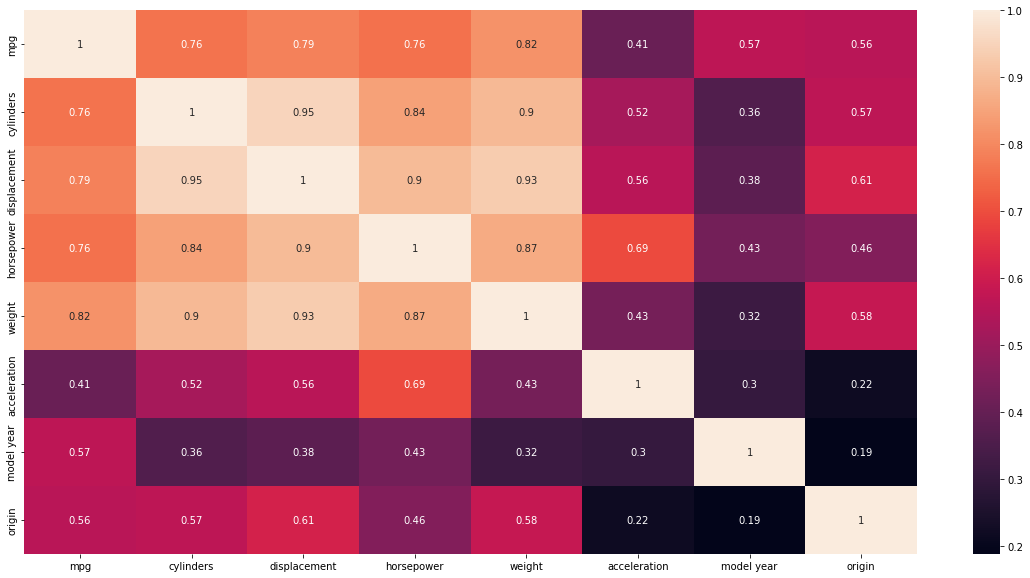

In [49]:
#Create a correlation matrix for the data. There appears to be a number of features that are highly correlated with weight, displacement, cylinders and mpg.
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(),  annot=True)

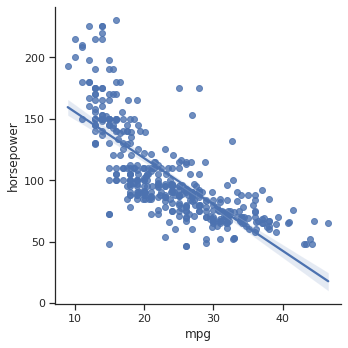

In [50]:
sns.set_theme(style="ticks")

# Chart of the original dataset
sns.lmplot(x="mpg", y="horsepower", data=data)

In [51]:
original_test_df = test_df.toPandas()
original_test_df.head()

,features,horsepower,mpg
0,[12.0],167,12
1,[12.0],198,12
2,[13.0],140,13
3,[13.0],145,13
4,[14.0],148,14


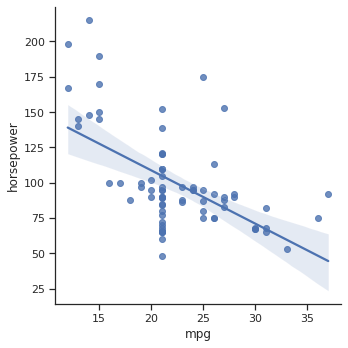

In [52]:
sns.set_theme(style="ticks")

# Chart of original test dataset
sns.lmplot(x="mpg", y="horsepower", data=original_test_df)

In [53]:
pd_predictions = predictions.toPandas()
pd_predictions.head()

,features,horsepower,mpg,prediction
0,[12.0],167,12,145.244238
1,[12.0],198,12,145.244238
2,[13.0],140,13,141.040360
3,[13.0],145,13,141.040360
4,[14.0],148,14,136.836483


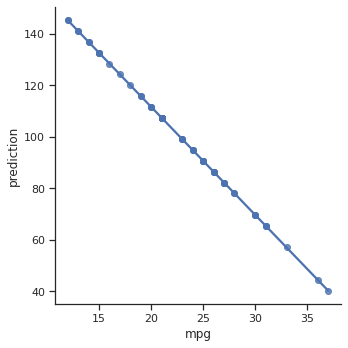

In [54]:
sns.set_theme(style="ticks")

# Show the results of a linear regression within each dataset
sns.lmplot(x="mpg", y="prediction", data=pd_predictions)

In [55]:
#select features from dataframe and transform data
supervised_mpg = RFormula(formula="mpg ~ .")
fittedRF_mpg = supervised_mpg.fit(car_df)
preparedDF_mpg = fittedRF_mpg.transform(car_df)
preparedDF_mpg.show(10, False)

+---+---------+------------+----------+------+------------+----------+------+---------+------------------------------------------------------------------+-----+
|mpg|cylinders|displacement|horsepower|weight|acceleration|model year|origin|carName  |features                                                          |label|
+---+---------+------------+----------+------+------------+----------+------+---------+------------------------------------------------------------------+-----+
|15 |8        |350         |165       |3693  |11.5        |70        |1     |buick    |(44,[0,1,2,3,4,5,6,14],[8.0,350.0,165.0,3693.0,11.5,70.0,1.0,1.0])|15.0 |
|18 |8        |318         |150       |3436  |11.0        |70        |1     |plymouth |(44,[0,1,2,3,4,5,6,9],[8.0,318.0,150.0,3436.0,11.0,70.0,1.0,1.0]) |18.0 |
|16 |8        |304         |150       |3433  |12.0        |70        |1     |amc      |(44,[0,1,2,3,4,5,6,10],[8.0,304.0,150.0,3433.0,12.0,70.0,1.0,1.0])|16.0 |
|17 |8        |302         |140   

In [56]:
#Create an 80/20 train/test split
train_df, test_df = preparedDF_mpg.randomSplit([0.8, 0.2])

In [57]:
#Create an instance of linear regression and fit the model
lr = LinearRegression(featuresCol = 'features', labelCol='mpg', maxIter=20, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
# Retrieve coeffients and intercept
print("Beta Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Beta Coefficients: [-0.11239501593374156,0.0,-0.0121124910081065,-0.0035878475312511177,0.0,0.2413957112651524,0.0,-0.5232534534164858,0.0,0.0,-0.28386805974023865,0.0,0.0,0.16941084030788423,0.0,0.0,0.0,0.0,0.0,-0.4948880689360844,0.0,0.3911724427033135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8371296147204934,-2.899020991701557,2.003798135078389,0.0,0.0,1.6845144686239457,0.0,0.0,5.0770499301988545,0.0,0.0]
Intercept: 15.898499856026469


In [58]:
#Retrieve the RMSE and Rsquare values, which both indicate that this is a model that we can possibly work with

trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 3.994696
r2: 0.552513


In [59]:
#display predictions based on test data
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","mpg","features").show(10, False)

+------------------+---+--------------------------------------------------------------------------------+
|prediction        |mpg|features                                                                        |
+------------------+---+--------------------------------------------------------------------------------+
|13.237935197674929|11 |(44,[0,1,2,3,4,5,6,18],[8.0,429.0,208.0,4633.0,11.0,72.0,1.0,1.0])              |
|12.473207210824407|12 |(44,[0,1,2,3,4,5,6,7],[8.0,400.0,167.0,4906.0,12.5,73.0,1.0,1.0])               |
|16.556579500107762|13 |(44,[0,1,2,3,4,5,6,8],[8.0,350.0,145.0,3988.0,13.0,73.0,1.0,1.0])               |
|11.577212991332974|13 |(44,[0,1,2,3,4,5,6,15],[8.0,400.0,175.0,5140.0,12.0,71.0,1.0,1.0])              |
|14.21299586491483 |13 |(44,[0,1,2,3,4,5,6,24],[8.0,400.0,190.0,4422.0,12.5,72.0,1.0,1.0])              |
|17.010499215534878|14 |(44,[0,1,2,3,4,5,6,9],[8.0,340.0,160.0,3609.0,8.0,70.0,1.0,1.0])                |
|24.9098533069135  |15 |(44,[0,1,2,3,4,5,6,16]

In [60]:
# use regression evaluator to get the r2 value which appears to be something that we can work with
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="mpg",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.456423


In [61]:
#perform model evaluation to get the RMSE which also appears to be something that we can work with
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 3.98246


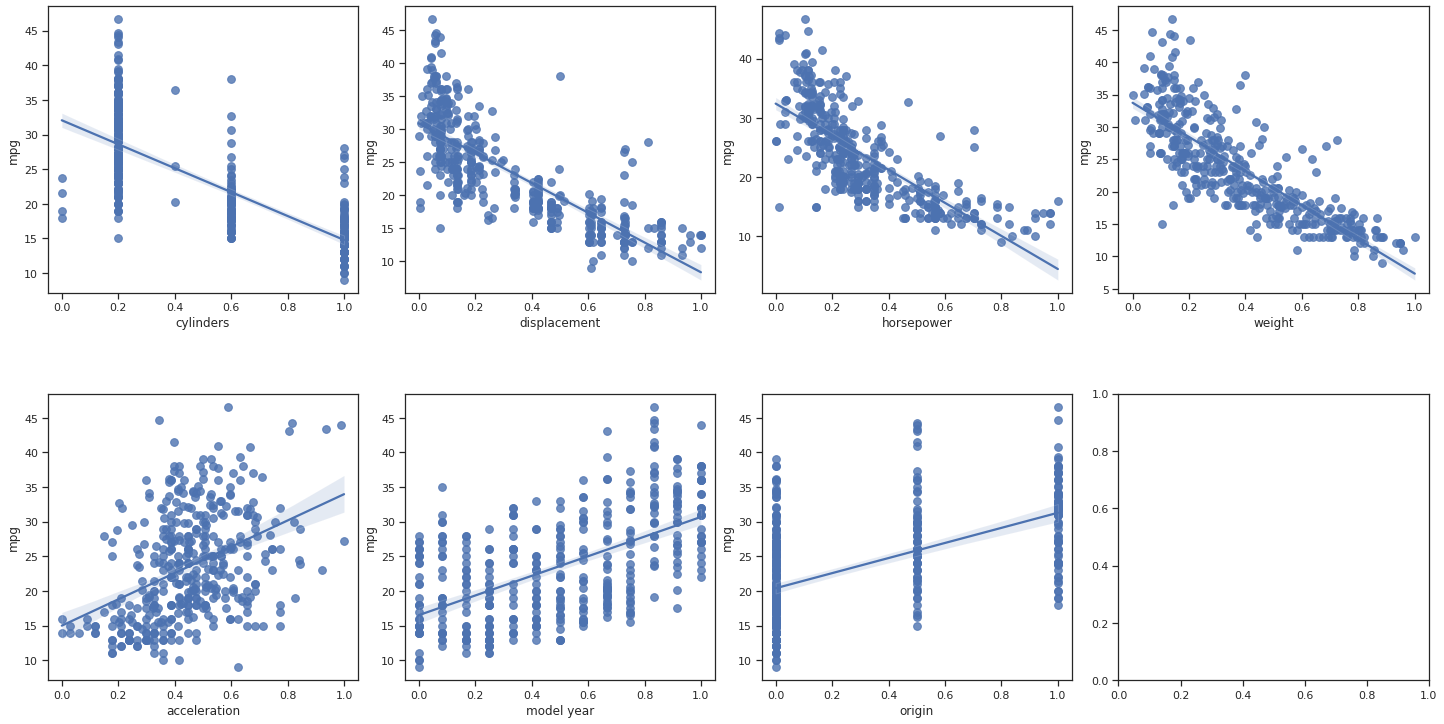

In [63]:
#After plotting our data it appears that the most important features are displacement, horsepower, weight and acceleration

from sklearn import preprocessing
# Let's scale the columns before plotting them against MEDV
min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
x = data.loc[:,column_sels]
y = data['mpg']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i],scatter_kws={"s": 60} )
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [64]:
# Instatiate an instance of Decision Tree Regressor
from pyspark.ml.regression import DecisionTreeRegressor

# fit the model
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'mpg')
dt_model = dt.fit(train_df)

In [65]:
#Check predictions and calculate RMSE. The RMSE appears to be slightly lower than the one for linear regression 
#which is a good indication 

dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="mpg", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.4363


In [66]:
dt_model.featureImportances

SparseVector(44, {0: 0.4609, 1: 0.0804, 2: 0.0077, 3: 0.0952, 4: 0.0012, 5: 0.326, 7: 0.0013, 9: 0.0266, 25: 0.0007})